## Kaggle Competition 

Prediction interval competition II: House price competition, where the objective is to create a regression model for the sale price of a house that overall has the narrowest prediction intervals.

In [1]:
# install dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the datasets
df = pd.read_csv('dataset.csv', index_col="id", parse_dates=["sale_date"])
df_test = pd.read_csv('test.csv', index_col="id", parse_dates=["sale_date"])
df.info() # Following columns are mising values: sale_nbr, subdivision, submarket

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 0 to 199999
Data columns (total 46 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   sale_date         200000 non-null  datetime64[ns]
 1   sale_price        200000 non-null  int64         
 2   sale_nbr          157818 non-null  float64       
 3   sale_warning      200000 non-null  object        
 4   join_status       200000 non-null  object        
 5   join_year         200000 non-null  int64         
 6   latitude          200000 non-null  float64       
 7   longitude         200000 non-null  float64       
 8   area              200000 non-null  int64         
 9   city              200000 non-null  object        
 10  zoning            200000 non-null  object        
 11  subdivision       182450 non-null  object        
 12  present_use       200000 non-null  int64         
 13  land_val          200000 non-null  int64         
 14  imp_val  

### Exploratory Data Analysis

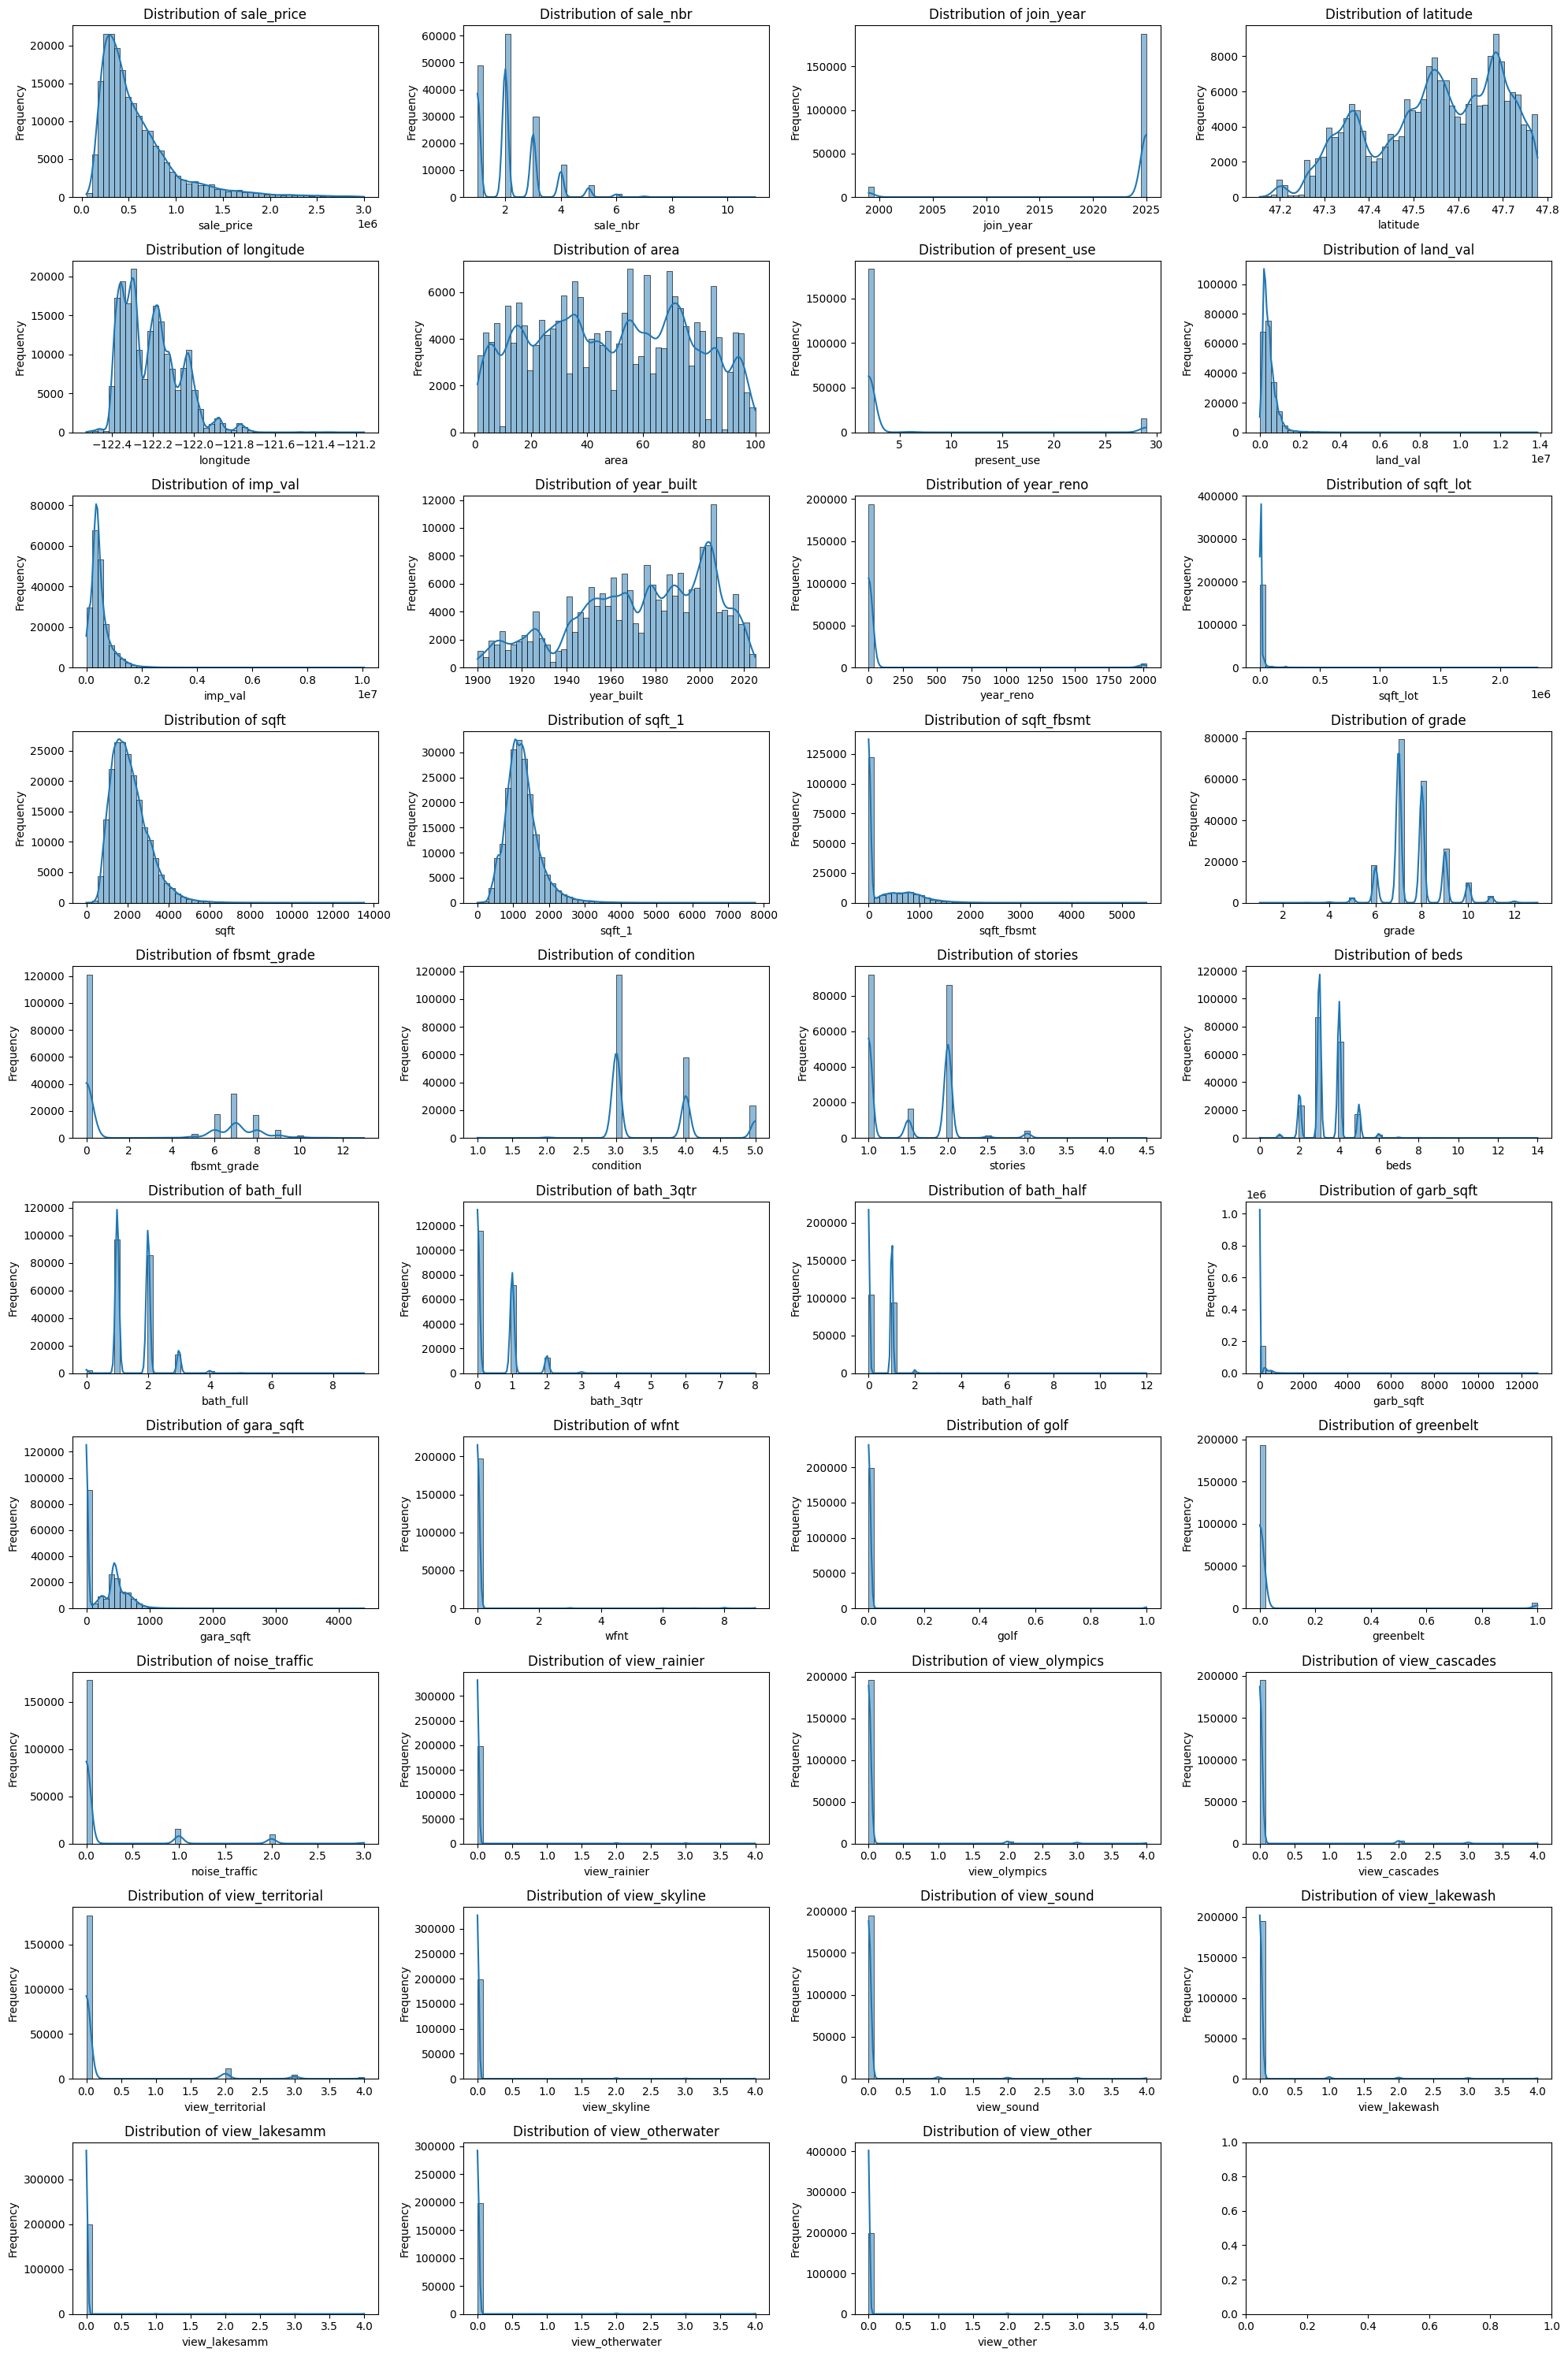

In [47]:
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(exclude=[np.number]).columns.tolist()

# Plot numeric features in a grid
n_cols = 4
n_rows = int(np.ceil(len(numeric_features) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 3))
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    sns.histplot(df[feature], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

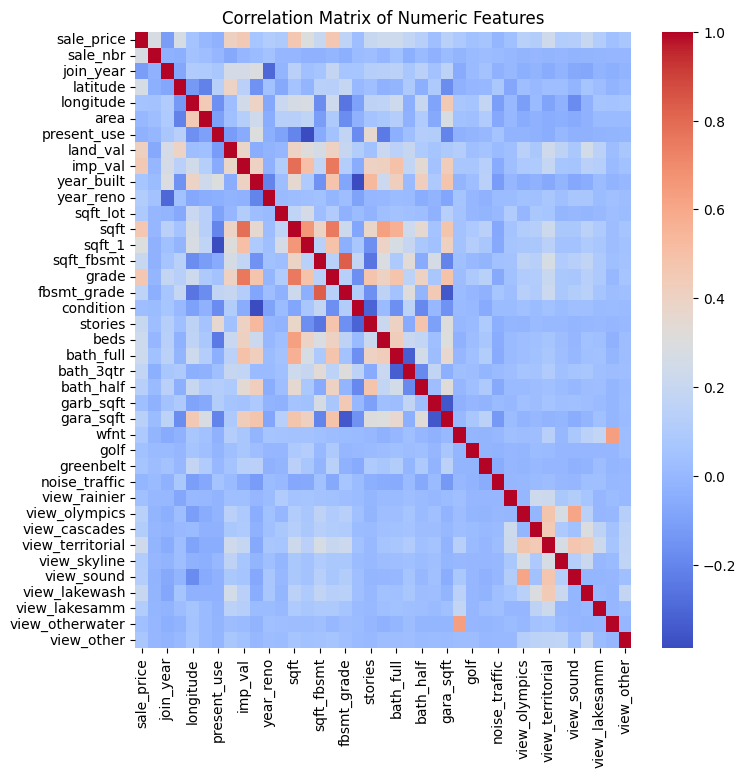

In [48]:
# Create correlation matrix heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(df[numeric_features].corr(), annot=False, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Numeric Features")
plt.show()

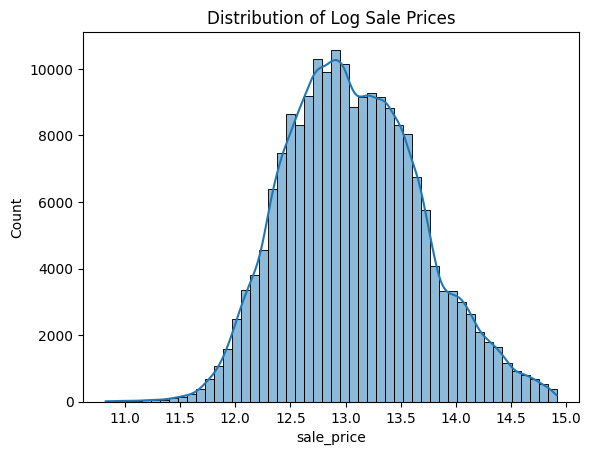

In [49]:
# plot log sale price
sns.histplot(np.log1p(df.sale_price), bins=50, kde=True) # sale price is approximately log-normal
plt.title("Distribution of Log Sale Prices");

### Feature Engineering

In [3]:
def feature_engineering(df):
    """Perform feature engineering on the dataset."""
    df = df.copy() # Avoid modifying the original dataframe

    # Create date features
    df['sale_year'] = df.sale_date.dt.year
    df['sale_month'] = df.sale_date.dt.month
    df['sale_quarter'] = df.sale_date.dt.quarter
    df['week_of_year'] = df.sale_date.dt.isocalendar().week

    # Age of the house at sale date
    df['house_age'] = df.sale_year - df.year_built

    # Year since last remodel
    df['years_since_remodel'] = df.sale_year - df.year_reno

    # Convert binary features to 0/1
    df['has_waterfront'] = (df['wfnt'] > 0).fillna(0).astype(int)
    df['is_golf'] = df['golf'].fillna(0).astype(int)
    df['is_greenbelt'] = df['greenbelt'].fillna(0).astype(int)
    df['has_traffic_noise'] = df['noise_traffic'].fillna(0).astype(int)
    df['has_rainier_view'] = df['view_rainier'].fillna(0).astype(int)
    df['has_olympics_view'] = df['view_olympics'].fillna(0).astype(int)
    df['has_cascades_view'] = df['view_cascades'].fillna(0).astype(int)

    # Drop original features that are no longer needed
    df.drop(columns=['sale_date', 'wfnt', 'golf', 'greenbelt', 'noise_traffic', 
                     'view_rainier', 'view_olympics', 'view_cascades'], inplace=True)

    # Filter out categorical features with too many unique values
    categorical_features = [col for col in df.select_dtypes(include=['object']).columns if df[col].nunique() <= 50]
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    df = df[categorical_features + numeric_features]

    return df


df = feature_engineering(df)
df_test = feature_engineering(df_test)

### Data Preperation

In [4]:
# test train split
X_train, X_val, y_train, y_val = train_test_split(df.drop(columns=["sale_price"]), df.sale_price, test_size=0.2, random_state=42) 

X_test = df_test.copy()
X_test = X_test[X_train.columns]  # Ensure test set has same features as training

In [ ]:
# One Hot encoding categorical features
def one_hot_encode(df, categorical_features):
    """One Hot Encoding encode categorical features."""
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_features = encoder.fit_transform(df[categorical_features])
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features), index=df.index)
    return encoded_df

def preprocess_data(df, numeric_features, num_imputer, cat_imputer, categorical_features, scale_numeric=False):
    """Preprocess the data by imputing missing values and encoding categorical features."""
    # Impute missing values
    df[numeric_features] = num_imputer.transform(df[numeric_features])
    df[categorical_features] = cat_imputer.transform(df[categorical_features])

    # One-hot encode categorical features
    encoded_df = one_hot_encode(df, categorical_features)

    # Combine numeric and encoded categorical features
    processed_df = pd.concat([df[numeric_features], encoded_df], axis=1)

    # Scale numeric features (optional, depending on the model)
    scaler = StandardScaler()
    if scale_numeric:
        processed_df[numeric_features] = scaler.fit_transform(processed_df[numeric_features])
    
    return processed_df


In [5]:
# Preprocess the training and test datasets
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

# Initialize imputers
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')

# Impute missing values in numeric and categorical features
X_train[numeric_features] = num_imputer.fit_transform(X_train[numeric_features])
X_train[categorical_features] = cat_imputer.fit_transform(X_train[categorical_features])

X_val[numeric_features] = num_imputer.transform(X_val[numeric_features])
X_val[categorical_features] = cat_imputer.transform(X_val[categorical_features])

X_test[numeric_features] = num_imputer.transform(X_test[numeric_features])
X_test[categorical_features] = cat_imputer.transform(X_test[categorical_features])

In [6]:
# One-hot encode categorical features
# encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train[categorical_features] = encoder.fit_transform(X_train[categorical_features])
X_val[categorical_features] = encoder.transform(X_val[categorical_features])
X_test[categorical_features] = encoder.transform(X_test[categorical_features])

### Model Fitting

#### Neural Network
Use a black-box neural network to specify output to be an interval.

In [7]:
# Create copies of the datasets to avoid modifying the original data
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

# Standardize the numeric features
scaler = StandardScaler()
# Fit the scaler on the numeric features of the training data
X_train_scaled[numeric_features] = scaler.fit_transform(X_train_scaled[numeric_features])
X_val_scaled[numeric_features] = scaler.transform(X_val_scaled[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test_scaled[numeric_features])

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class WinklerLoss(nn.Module): 
    """
    Winkler Loss for quantile regression.
    This loss function is designed to penalize the model based on the width of the predicted quantile intervals.
    It applies a penalty when the true value falls outside the predicted interval.
    """
    def __init__(self, alpha=0.1):
        super().__init__()
        self.alpha = alpha

    def forward(self, y_true, pred):
        # Ensure shapes are compatible
        y_true = y_true.view(-1)  # Flatten y_true to ensure it is 1D
        lower = pred[:, 0]
        upper = pred[:, 1]
        width = upper - lower
        penalty_lower = 2 / self.alpha * (lower - y_true)
        penalty_upper = 2 / self.alpha * (y_true - upper)
        score = width.clone()
        # Apply penalties for values outside the interval
        score += torch.where(y_true < lower, penalty_lower, torch.zeros_like(y_true))
        score += torch.where(y_true > upper, penalty_upper, torch.zeros_like(y_true))
        return score.mean()

In [9]:
class IntervalNet(nn.Module):
    """A neural network model that predicts intervals for quantile regression.
    The model outputs two values: lower and upper bounds of the interval.
    The upper bound is ensured to be greater than or equal to the lower bound.
    """
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # Output: [lower, upper]
        )

    def forward(self, x):
        out = self.net(x)
        # Optionally enforce lower < upper:
        lower = out[:, 0:1]
        upper = out[:, 1:2]
        upper = lower + torch.abs(upper)  # ensures upper >= lower
        return torch.cat([lower, upper], dim=1)

Epoch 0: Train Loss=897579.38, Val Loss=1330233.38
Epoch 10: Train Loss=760883.75, Val Loss=697213.88
Epoch 20: Train Loss=602519.81, Val Loss=629925.19
Epoch 30: Train Loss=463322.56, Val Loss=568791.88
Epoch 40: Train Loss=427022.19, Val Loss=544000.12
Epoch 50: Train Loss=646653.69, Val Loss=528032.75
Epoch 60: Train Loss=467378.81, Val Loss=515377.91
Epoch 70: Train Loss=456170.12, Val Loss=502936.00
Epoch 80: Train Loss=483919.19, Val Loss=492478.56
Epoch 90: Train Loss=655497.12, Val Loss=482004.03


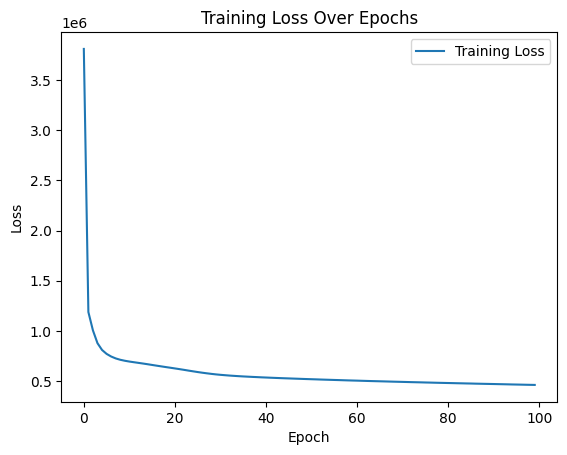

In [17]:
# Prepare data as torch tensors
X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val_scaled.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

model = IntervalNet(input_dim=X_train_tensor.shape[1])
loss_fn = WinklerLoss(alpha=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


n_epochs = 100
losses = []
# Training loop
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0
    batch_count = 0
    for X_batch, y_batch in train_loader:
        # Zero gradients, forward pass, compute loss, backward pass, and update weights
        optimizer.zero_grad()
        pred = model(X_batch)
        loss = loss_fn(y_batch, pred)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        batch_count += 1
    avg_epoch_loss = epoch_loss / batch_count
    losses.append(avg_epoch_loss)
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_tensor)
            val_loss = loss_fn(y_val_tensor, val_pred)
        print(f"Epoch {epoch}: Train Loss={loss.item():.2f}, Val Loss={val_loss.item():.2f}")
        

# Plot loss over epochs
plt.plot(range(n_epochs), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend();

In [ ]:
# Generate predictions on the test set
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)
    test_predictions = model(X_test_tensor)
# Convert predictions to DataFrame
test_predictions_df = pd.DataFrame(test_predictions.numpy(), columns=['pi_lower', 'pi_upper'], index=X_test.index)

In [23]:
ALPHA = .1 # Define nominal coverage level
random_state = 42 # For reproducibility

# From PI-II: Demo QRF
def winkler_score(y_true, lower, upper, alpha=ALPHA, return_coverage=False):
    """Compute the Winkler Interval Score for prediction intervals.

    Args:
        y_true (array-like): True observed values.
        lower (array-like): Lower bounds of prediction intervals.
        upper (array-like): Upper bounds of prediction intervals.
        alpha (float): Significance level (e.g., 0.1 for 90% intervals).
        return_coverage (bool): If True, also return empirical coverage.

    Returns:
        score (float): Mean Winkler Score.
        coverage (float, optional): Proportion of true values within intervals.
    """
    y_true = np.asarray(y_true)
    lower = np.asarray(lower)
    upper = np.asarray(upper)

    width = upper - lower
    penalty_lower = 2 / alpha * (lower - y_true)
    penalty_upper = 2 / alpha * (y_true - upper)

    score = width.copy()
    score += np.where(y_true < lower, penalty_lower, 0)
    score += np.where(y_true > upper, penalty_upper, 0)

    if return_coverage:
        inside = (y_true >= lower) & (y_true <= upper)
        coverage = np.mean(inside)
        return np.mean(score), coverage

    return np.mean(score)

Mean Winkler Score: 473021.75
Coverage: 89.8%


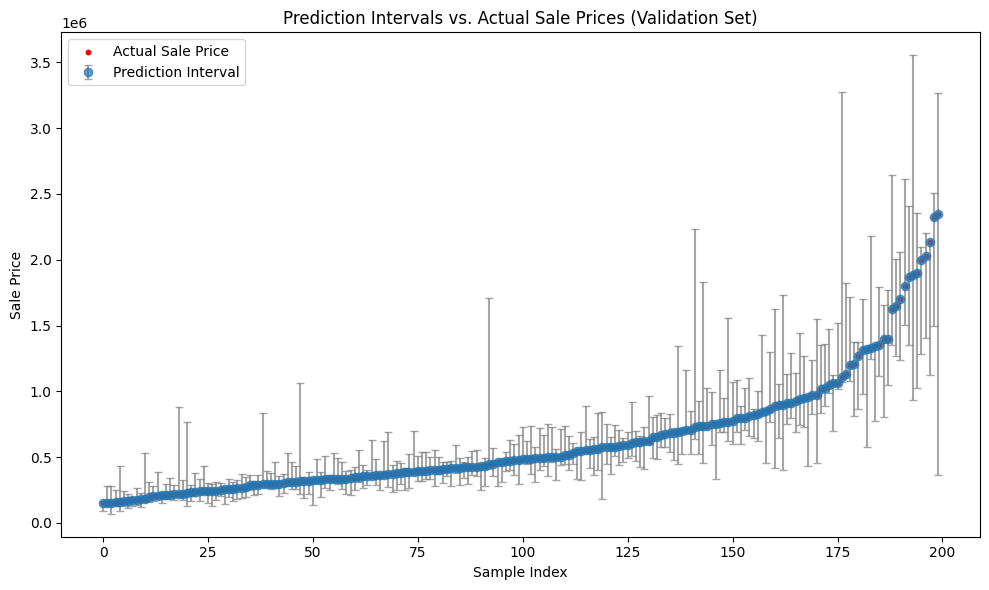

In [26]:
from matplotlib.ticker import FuncFormatter

# Generate prediction intervals for the validation set
model.eval()
with torch.no_grad():
    val_pred = model(X_val_tensor)
    pi_lower = val_pred[:, 0].numpy()
    pi_upper = val_pred[:, 1].numpy()

# Build DataFrame for evaluation
y_val_pred = pd.DataFrame({
    "pi_lower": pi_lower,
    "pi_upper": pi_upper
}, index=y_val.index)

# Calculate Winkler score and coverage
alpha = 0.1  # Nominal coverage level

mws, coverage = winkler_score(
    y_val,
    y_val_pred["pi_lower"],
    y_val_pred["pi_upper"],
    alpha=alpha,
    return_coverage=True,
)
print(f"Mean Winkler Score: {mws:.2f}")
print(f"Coverage: {coverage * 100:.1f}%")

# Visualization: Prediction intervals vs. actuals
plt.figure(figsize=(10, 6))
sample_idx = np.random.choice(len(y_val), size=200, replace=False)
sorted_idx = np.argsort(y_val.values[sample_idx])

# Calculate non-negative error bars
lower_errors = np.maximum(y_val.values[sample_idx][sorted_idx] - y_val_pred["pi_lower"].values[sample_idx][sorted_idx], 0)
upper_errors = np.maximum(y_val_pred["pi_upper"].values[sample_idx][sorted_idx] - y_val.values[sample_idx][sorted_idx], 0)

plt.errorbar(
    np.arange(len(sample_idx)),
    y_val.values[sample_idx][sorted_idx],
    yerr=[lower_errors, upper_errors],
    fmt='o', ecolor='gray', alpha=0.7, capsize=3, label='Prediction Interval'
)
plt.scatter(
    np.arange(len(sample_idx)),
    y_val.values[sample_idx][sorted_idx],
    color='red', s=10, label='Actual Sale Price'
)
plt.xlabel("Sample Index")
plt.ylabel("Sale Price")
plt.title("Prediction Intervals vs. Actual Sale Prices (Validation Set)")
plt.legend()
plt.tight_layout()
plt.show()

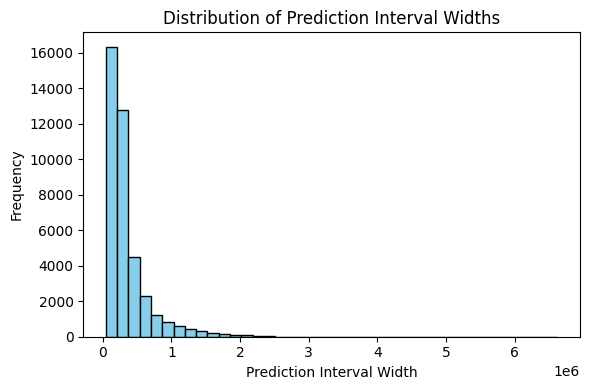

In [ ]:
# Distribution of prediction interval widths
interval_widths = y_val_pred["pi_upper"] - y_val_pred["pi_lower"]
plt.figure(figsize=(6,4))
plt.hist(interval_widths, bins=40, color='skyblue', edgecolor='k')
plt.xlabel("Prediction Interval Width")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Interval Widths")
plt.tight_layout()
plt.show()

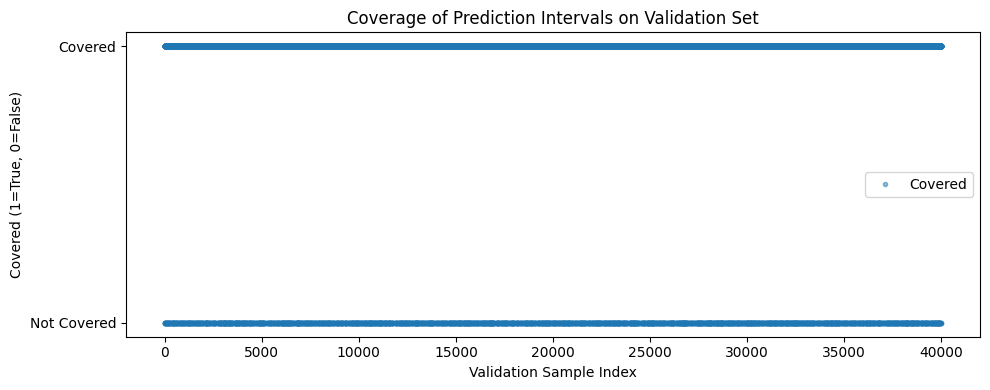

In [31]:
# Coverage plot: visualize which validation samples are covered by the prediction interval
plt.figure(figsize=(10, 4))
covered = (y_val >= y_val_pred["pi_lower"]) & (y_val <= y_val_pred["pi_upper"])
plt.plot(np.arange(len(y_val)), covered.values, '.', alpha=0.5, label='Covered')
plt.xlabel("Validation Sample Index")
plt.ylabel("Covered (1=True, 0=False)")
plt.title("Coverage of Prediction Intervals on Validation Set")
plt.yticks([0, 1], ["Not Covered", "Covered"])
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
# Save predictions to CSV
test_predictions_df.reset_index().to_csv('submission.csv', index=False)

In [32]:
df.sale_price.describe()

count    2.000000e+05
mean     5.841495e+05
std      4.170595e+05
min      5.029300e+04
25%      3.050000e+05
50%      4.599500e+05
75%      7.249500e+05
max      2.999950e+06
Name: sale_price, dtype: float64